# ResNet10 Performance
Upload [resnet.py](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py) to session storage first.

In [1]:
from resnet import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
# import argparse

# from models import *
# from utils import progress_bar


## Preparing Data<sup>[1](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)



In [3]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:05<00:00, 29165047.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Build Model<sup>[1](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)


In [4]:
# Model
print('==> Building model..')
# net = VGG('VGG19')
# net = ResNet18()
net = ResNet(BasicBlock, [1, 1, 1, 1])
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

'''if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']'''

criterion = nn.CrossEntropyLoss()
'''optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)'''
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


## Define Train Function<sup>[1](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [5]:
# Training
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        '''progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))'''
    aver_train_loss = float(train_loss/(batch_idx+1))
    aver_train_accuracy = float(correct/total)
    return aver_train_loss, aver_train_accuracy

## Define Test Function<sup>[1](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [6]:
best_acc = 0  # best test accuracy
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            '''progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))'''

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {'net': net.state_dict(), 'acc': acc, 'epoch': epoch,}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

    aver_test_loss = float(test_loss / (batch_idx + 1))
    aver_test_accuracy = float(correct / total)
    return aver_test_loss, aver_test_accuracy

## Training and Test

In [7]:
import json
import collections

EPOCH = 200
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
JSON_FILE = '../epoch_data_Resnet10_cos_steplr.json'
epoch_data = collections.OrderedDict()
for epoch in range(start_epoch, start_epoch+200):
    train_loss, train_accuracy = train(epoch)
    epoch_data[epoch] = {'train_loss': train_loss, 'train_accuracy': train_accuracy}
    test_loss, test_accuracy = test(epoch)
    epoch_data[epoch]['test_loss'], epoch_data[epoch]['test_accuracy'] = test_loss, test_accuracy
    scheduler.step()
    if epoch % 10 == 9:
      print(f'Epoch {epoch+1}/{EPOCH}, Train Loss {train_loss:.5f}, Train Acc {train_accuracy:.5f}, Test Loss {test_loss:.5f}, Test Acc {test_accuracy:.5f}')

epoch_data_json = json.dumps(epoch_data)
json_file = open(JSON_FILE, 'w')
json_file.write(epoch_data_json)
json_file.close()
print(f'Best Acc: {best_acc}%')

Epoch 10/200, Train Loss 0.47432, Train Acc 0.83534, Test Loss 0.56406, Test Acc 0.80730
Epoch 20/200, Train Loss 0.38589, Train Acc 0.86758, Test Loss 0.54528, Test Acc 0.81810
Epoch 30/200, Train Loss 0.35970, Train Acc 0.87706, Test Loss 0.44335, Test Acc 0.85140
Epoch 40/200, Train Loss 0.33923, Train Acc 0.88324, Test Loss 0.92089, Test Acc 0.75060
Epoch 50/200, Train Loss 0.32327, Train Acc 0.88788, Test Loss 0.52854, Test Acc 0.83210
Epoch 60/200, Train Loss 0.29813, Train Acc 0.89582, Test Loss 0.40597, Test Acc 0.86480
Epoch 70/200, Train Loss 0.28720, Train Acc 0.90032, Test Loss 0.36630, Test Acc 0.87850
Epoch 80/200, Train Loss 0.26230, Train Acc 0.90904, Test Loss 0.54987, Test Acc 0.82430
Epoch 90/200, Train Loss 0.24262, Train Acc 0.91540, Test Loss 0.44345, Test Acc 0.85980
Epoch 100/200, Train Loss 0.21446, Train Acc 0.92534, Test Loss 0.36354, Test Acc 0.87840
Epoch 110/200, Train Loss 0.18926, Train Acc 0.93504, Test Loss 0.37249, Test Acc 0.88690
Epoch 120/200, Trai

## Data Analysis<sup>

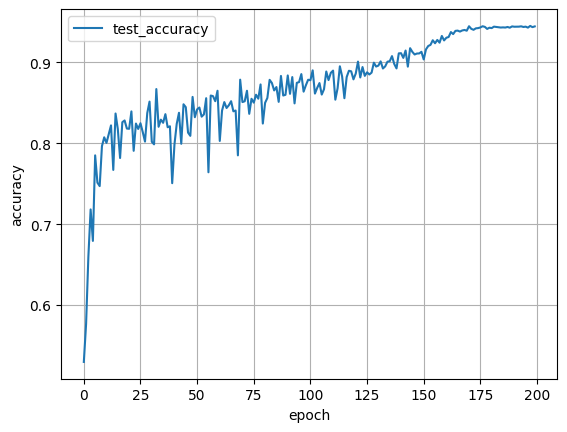

In [8]:
import matplotlib.pyplot as plt

f = open(JSON_FILE)
data1 = json.load(f)
f.close()

FEATURE = 'test_accuracy'

x = [i for i in range(EPOCH)]
feature1 = [data1[str(k)][FEATURE] for k in range(EPOCH)]

plt.plot(x, feature1, label=FEATURE)
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()
